# K & M Matrix Comparison: Python vs MATLAB

This notebook compares Python-generated K & M matrices with MATLAB ground truth.
Cells can be run independently to inspect intermediate results.


In [1]:
import numpy as np
import scipy.sparse as sp
import torch
from pathlib import Path
import h5py

# Configuration
python_data_dir = Path(r'D:\Research\NO-2D-Metamaterials\data\out_test_10\out_binarized_1')
matlab_mat_file = Path(r'D:\Research\NO-2D-Metamaterials\2D-dispersion-han\OUTPUT\out_test_10\out_binarized_1.mat')
struct_idx = 0

## Load Python Matrices


In [2]:
# Load K and M matrices from Python .pt files
K_data = torch.load(python_data_dir / 'K_data.pt', map_location='cpu')
M_data = torch.load(python_data_dir / 'M_data.pt', map_location='cpu')

K_py = K_data[struct_idx]
M_py = M_data[struct_idx]

if not sp.issparse(K_py):
    K_py = sp.csr_matrix(K_py)
if not sp.issparse(M_py):
    M_py = sp.csr_matrix(M_py)

print(f"Python K: shape={K_py.shape}, nnz={K_py.nnz}")
print(f"Python M: shape={M_py.shape}, nnz={M_py.nnz}")


Python K: shape=(2178, 2178), nnz=30348
Python M: shape=(2178, 2178), nnz=18818


C:\Users\hz283\AppData\Local\Temp\ipykernel_230212\2767131978.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  K_data = torch.load(python_data_dir / 'K_data.pt', map_loca

## Load MATLAB Matrices


In [3]:
# Load K and M matrices from MATLAB .mat file (HDF5 format)
with h5py.File(matlab_mat_file, 'r') as f:
    # Get references to K_DATA and M_DATA
    K_DATA_ref = f['K_DATA'][struct_idx, 0]
    M_DATA_ref = f['M_DATA'][struct_idx, 0]
    
    # Extract sparse matrix data
    K_data = np.array(f[K_DATA_ref]['data']).flatten()
    K_ir = np.array(f[K_DATA_ref]['ir']).flatten()
    K_jc = np.array(f[K_DATA_ref]['jc']).flatten()
    
    M_data = np.array(f[M_DATA_ref]['data']).flatten()
    M_ir = np.array(f[M_DATA_ref]['ir']).flatten()
    M_jc = np.array(f[M_DATA_ref]['jc']).flatten()
    
    # Get shape (should be (2178, 2178))
    n = len(K_jc) - 1
    
    # Create sparse matrices
    K_ml = sp.csr_matrix((K_data, K_ir, K_jc), shape=(n, n))
    M_ml = sp.csr_matrix((M_data, M_ir, M_jc), shape=(n, n))

print(f"MATLAB K: shape={K_ml.shape}, nnz={K_ml.nnz}")
print(f"MATLAB M: shape={M_ml.shape}, nnz={M_ml.nnz}")


MATLAB K: shape=(2178, 2178), nnz=30348
MATLAB M: shape=(2178, 2178), nnz=18818


## Compare K Matrices


In [4]:
# Basic shape and sparsity check
print("K Matrix Comparison")
print(f"  Python: shape={K_py.shape}, nnz={K_py.nnz}")
print(f"  MATLAB: shape={K_ml.shape}, nnz={K_ml.nnz}")
print(f"  Shapes match: {K_py.shape == K_ml.shape}")
print(f"  nnz match: {K_py.nnz == K_ml.nnz}")


K Matrix Comparison
  Python: shape=(2178, 2178), nnz=30348
  MATLAB: shape=(2178, 2178), nnz=30348
  Shapes match: True
  nnz match: True


Difference matrix nnz: 30422
Frobenius norm of difference: 1.553819e+13
Relative norm difference: 9.883855e-01


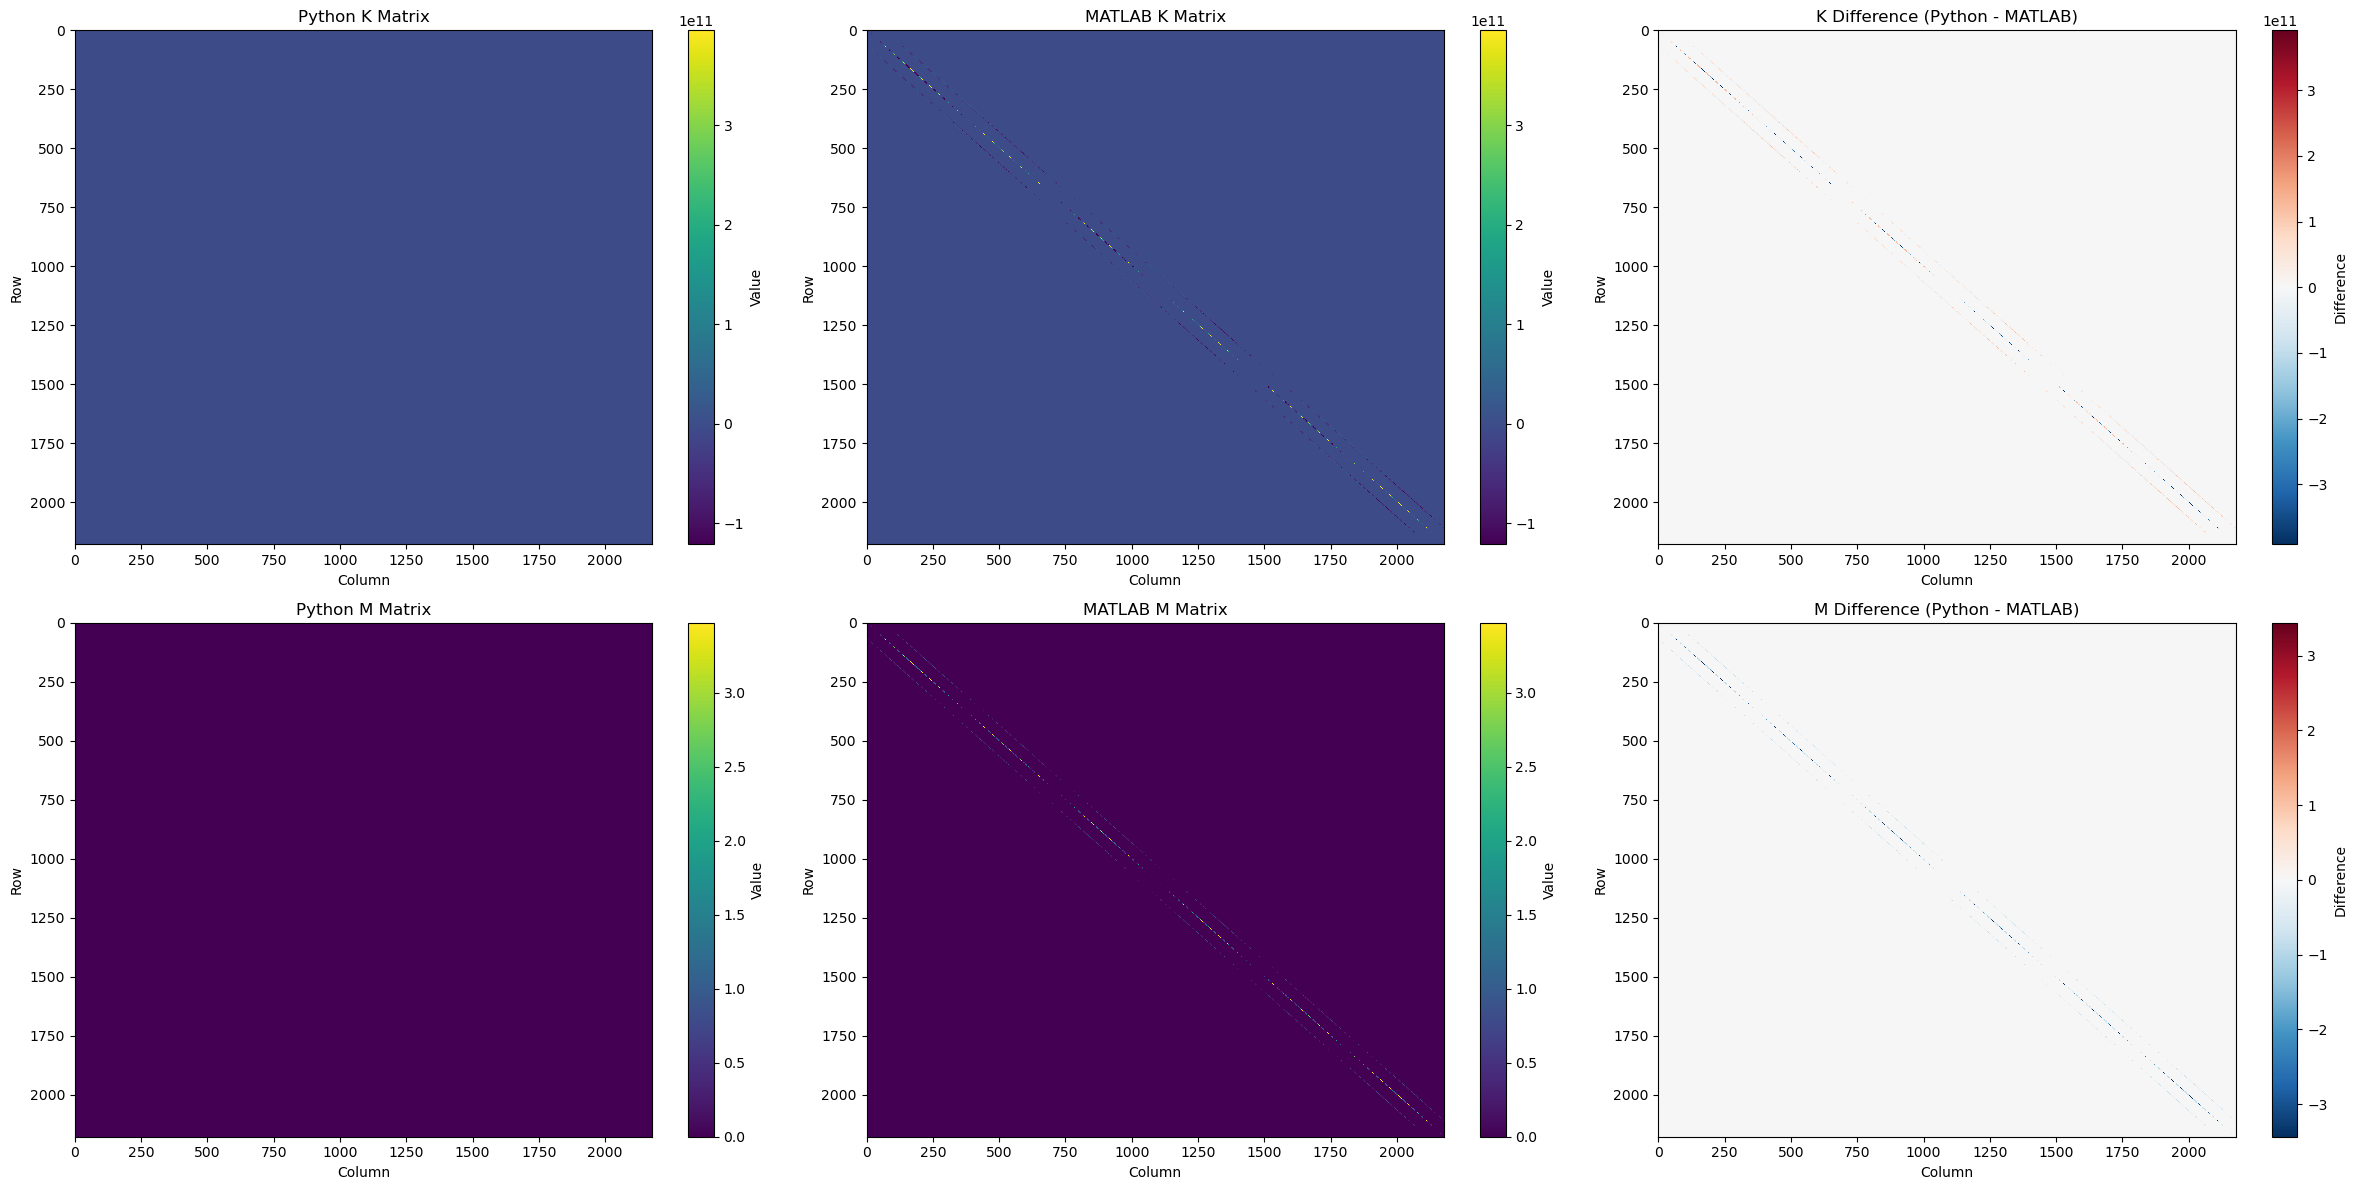


K matrices range: [-1.208791e+11, 3.956044e+11]
M matrices range: [0.000000e+00, 3.472222e+00]
K difference: max=3.911600e+11, mean=3.102360e+08
M difference: max=3.437500e+00, mean=2.475406e-03


In [5]:
# Compute difference matrix
diff_K = K_py - K_ml
print(f"Difference matrix nnz: {diff_K.nnz}")

# Compute norm of difference (fast)
diff_K_norm = sp.linalg.norm(diff_K)
K_ml_norm = sp.linalg.norm(K_ml)
relative_norm_diff_K = diff_K_norm / (K_ml_norm + 1e-8)

print(f"Frobenius norm of difference: {diff_K_norm:.6e}")
print(f"Relative norm difference: {relative_norm_diff_K:.6e}")

# Also compute M difference for visualization
diff_M = M_py - M_ml

# Visualize matrices as heatmaps (2 rows x 3 columns)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(24, 12))

# Convert to dense arrays and compute shared ranges
K_py_dense = K_py.toarray()
K_ml_dense = K_ml.toarray()
M_py_dense = M_py.toarray()
M_ml_dense = M_ml.toarray()
diff_K_dense = diff_K.toarray()
diff_M_dense = diff_M.toarray()

# Compute shared colorbar ranges for K and M matrices
K_min = min(np.min(K_py_dense), np.min(K_ml_dense))
K_max = max(np.max(K_py_dense), np.max(K_ml_dense))
M_min = min(np.min(M_py_dense), np.min(M_ml_dense))
M_max = max(np.max(M_py_dense), np.max(M_ml_dense))

# Row 1: K matrices
# Python K
ax = axes[0, 0]
im1 = ax.imshow(K_py_dense, cmap='viridis', aspect='auto', interpolation='nearest', vmin=K_min, vmax=K_max)
ax.set_title('Python K Matrix')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
plt.colorbar(im1, ax=ax, label='Value')

# MATLAB K
ax = axes[0, 1]
im2 = ax.imshow(K_ml_dense, cmap='viridis', aspect='auto', interpolation='nearest', vmin=K_min, vmax=K_max)
ax.set_title('MATLAB K Matrix')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
plt.colorbar(im2, ax=ax, label='Value')

# K Difference
ax = axes[0, 2]
# Use symmetric colormap for differences (centered at zero)
vmax_K_diff = np.max(np.abs(diff_K_dense))
im3 = ax.imshow(diff_K_dense, cmap='RdBu_r', aspect='auto', interpolation='nearest', vmin=-vmax_K_diff, vmax=vmax_K_diff)
ax.set_title('K Difference (Python - MATLAB)')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
plt.colorbar(im3, ax=ax, label='Difference')

# Row 2: M matrices
# Python M
ax = axes[1, 0]
im4 = ax.imshow(M_py_dense, cmap='viridis', aspect='auto', interpolation='nearest', vmin=M_min, vmax=M_max)
ax.set_title('Python M Matrix')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
plt.colorbar(im4, ax=ax, label='Value')

# MATLAB M
ax = axes[1, 1]
im5 = ax.imshow(M_ml_dense, cmap='viridis', aspect='auto', interpolation='nearest', vmin=M_min, vmax=M_max)
ax.set_title('MATLAB M Matrix')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
plt.colorbar(im5, ax=ax, label='Value')

# M Difference
ax = axes[1, 2]
# Use symmetric colormap for differences (centered at zero)
vmax_M_diff = np.max(np.abs(diff_M_dense))
im6 = ax.imshow(diff_M_dense, cmap='RdBu_r', aspect='auto', interpolation='nearest', vmin=-vmax_M_diff, vmax=vmax_M_diff)
ax.set_title('M Difference (Python - MATLAB)')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
plt.colorbar(im6, ax=ax, label='Difference')

plt.tight_layout()
plt.show()

print(f"\nK matrices range: [{K_min:.6e}, {K_max:.6e}]")
print(f"M matrices range: [{M_min:.6e}, {M_max:.6e}]")
print(f"K difference: max={np.max(np.abs(diff_K_dense)):.6e}, mean={np.mean(np.abs(diff_K_dense)):.6e}")
print(f"M difference: max={np.max(np.abs(diff_M_dense)):.6e}, mean={np.mean(np.abs(diff_M_dense)):.6e}")


In [6]:
# Detailed value comparison (only if differences exist)
if diff_K.nnz > 0:
    abs_diff_vals = np.abs(diff_K.data)
    max_abs_diff = np.max(abs_diff_vals)
    mean_abs_diff = np.mean(abs_diff_vals)
    
    print(f"Max absolute difference: {max_abs_diff:.6e}")
    print(f"Mean absolute difference: {mean_abs_diff:.6e}")
    
    # Sample some locations for detailed comparison
    n_sample = min(100, diff_K.nnz)  # Reduced sample size for faster execution
    sample_indices = np.random.choice(diff_K.nnz, n_sample, replace=False) if diff_K.nnz > n_sample else np.arange(diff_K.nnz)
    sample_abs_diffs = abs_diff_vals[sample_indices]
    
    # Get corresponding values from original matrices
    diff_coords = np.array(list(zip(*diff_K.nonzero())))
    if len(diff_coords) > 0:
        sample_coords = diff_coords[sample_indices]
        ml_vals_sample = np.array([K_ml[i, j] for i, j in sample_coords])
        rel_diff_sample = sample_abs_diffs / (np.abs(ml_vals_sample) + 1e-8)
        max_rel_diff = np.max(rel_diff_sample)
        mean_rel_diff = np.mean(rel_diff_sample)
        
        print(f"Max relative difference (sampled {n_sample}): {max_rel_diff:.6e}")
        print(f"Mean relative difference (sampled {n_sample}): {mean_rel_diff:.6e}")
        
        # Show worst mismatches
        n_show = min(10, diff_K.nnz)
        worst_indices = np.argsort(abs_diff_vals)[-n_show:][::-1]
        print(f"\nWorst {n_show} mismatches:")
        for idx in worst_indices:
            i, j = diff_coords[idx]
            py_val = float(K_py[i, j])
            ml_val = float(K_ml[i, j])
            abs_diff = abs_diff_vals[idx]
            rel_diff = abs_diff / (abs(ml_val) + 1e-8)
            print(f"  [{i:4d}, {j:4d}]: Py={py_val:12.6e}, ML={ml_val:12.6e}, abs_diff={abs_diff:.6e}, rel_diff={rel_diff:.6e}")
else:
    print("✅ K matrices are identical!")


Max absolute difference: 3.911600e+11
Mean absolute difference: 4.837491e+10
Max relative difference (sampled 100): 1.060667e+00
Mean relative difference (sampled 100): 9.911352e-01

Worst 10 mismatches:
  [ 539,  539]: Py=4.444445e+09, ML=3.956044e+11, abs_diff=3.911600e+11, rel_diff=9.887654e-01
  [ 216,  216]: Py=4.444445e+09, ML=3.956044e+11, abs_diff=3.911600e+11, rel_diff=9.887654e-01
  [ 270,  270]: Py=4.444445e+09, ML=3.956044e+11, abs_diff=3.911600e+11, rel_diff=9.887654e-01
  [1741, 1741]: Py=4.444445e+09, ML=3.956044e+11, abs_diff=3.911600e+11, rel_diff=9.887654e-01
  [ 271,  271]: Py=4.444445e+09, ML=3.956044e+11, abs_diff=3.911600e+11, rel_diff=9.887654e-01
  [1952, 1952]: Py=4.444445e+09, ML=3.956044e+11, abs_diff=3.911600e+11, rel_diff=9.887654e-01
  [1887, 1887]: Py=4.444445e+09, ML=3.956044e+11, abs_diff=3.911600e+11, rel_diff=9.887654e-01
  [ 272,  272]: Py=4.444445e+09, ML=3.956044e+11, abs_diff=3.911600e+11, rel_diff=9.887654e-01
  [1740, 1740]: Py=4.444445e+09, ML=

In [7]:
# Check non-zero pattern (only for small matrices)
if K_py.shape[0] * K_py.shape[1] < 1e6:
    py_nnz_mask = (K_py != 0).toarray()
    ml_nnz_mask = (K_ml != 0).toarray()
    locations_match = np.array_equal(py_nnz_mask, ml_nnz_mask)
    print(f"Non-zero locations match: {locations_match}")
    
    if not locations_match:
        only_py = np.sum(py_nnz_mask & ~ml_nnz_mask)
        only_ml = np.sum(~py_nnz_mask & ml_nnz_mask)
        print(f"  Only Python non-zero: {only_py}")
        print(f"  Only MATLAB non-zero: {only_ml}")
else:
    print("Matrix too large for pattern comparison (would require converting to dense)")


Matrix too large for pattern comparison (would require converting to dense)


## Compare M Matrices


In [8]:
# Basic shape and sparsity check
print("M Matrix Comparison")
print(f"  Python: shape={M_py.shape}, nnz={M_py.nnz}")
print(f"  MATLAB: shape={M_ml.shape}, nnz={M_ml.nnz}")
print(f"  Shapes match: {M_py.shape == M_ml.shape}")
print(f"  nnz match: {M_py.nnz == M_ml.nnz}")


M Matrix Comparison
  Python: shape=(2178, 2178), nnz=18818
  MATLAB: shape=(2178, 2178), nnz=18818
  Shapes match: True
  nnz match: True


In [9]:
# Compute difference matrix
diff_M = M_py - M_ml
print(f"Difference matrix nnz: {diff_M.nnz}")

# Compute norm of difference (fast)
diff_M_norm = sp.linalg.norm(diff_M)
M_ml_norm = sp.linalg.norm(M_ml)
relative_norm_diff_M = diff_M_norm / (M_ml_norm + 1e-8)

print(f"Frobenius norm of difference: {diff_M_norm:.6e}")
print(f"Relative norm difference: {relative_norm_diff_M:.6e}")


Difference matrix nnz: 18818
Frobenius norm of difference: 1.380745e+02
Relative norm difference: 9.901914e-01


In [10]:
# Detailed value comparison (only if differences exist)
if diff_M.nnz > 0:
    abs_diff_vals = np.abs(diff_M.data)
    max_abs_diff = np.max(abs_diff_vals)
    mean_abs_diff = np.mean(abs_diff_vals)
    
    print(f"Max absolute difference: {max_abs_diff:.6e}")
    print(f"Mean absolute difference: {mean_abs_diff:.6e}")
    
    # Sample some locations for detailed comparison
    n_sample = min(100, diff_M.nnz)  # Reduced sample size for faster execution
    sample_indices = np.random.choice(diff_M.nnz, n_sample, replace=False) if diff_M.nnz > n_sample else np.arange(diff_M.nnz)
    sample_abs_diffs = abs_diff_vals[sample_indices]
    
    # Get corresponding values from original matrices
    diff_coords = np.array(list(zip(*diff_M.nonzero())))
    if len(diff_coords) > 0:
        sample_coords = diff_coords[sample_indices]
        ml_vals_sample = np.array([M_ml[i, j] for i, j in sample_coords])
        rel_diff_sample = sample_abs_diffs / (np.abs(ml_vals_sample) + 1e-8)
        max_rel_diff = np.max(rel_diff_sample)
        mean_rel_diff = np.mean(rel_diff_sample)
        
        print(f"Max relative difference (sampled {n_sample}): {max_rel_diff:.6e}")
        print(f"Mean relative difference (sampled {n_sample}): {mean_rel_diff:.6e}")
        
        # Show worst mismatches
        n_show = min(10, diff_M.nnz)
        worst_indices = np.argsort(abs_diff_vals)[-n_show:][::-1]
        print(f"\nWorst {n_show} mismatches:")
        for idx in worst_indices:
            i, j = diff_coords[idx]
            py_val = float(M_py[i, j])
            ml_val = float(M_ml[i, j])
            abs_diff = abs_diff_vals[idx]
            rel_diff = abs_diff / (abs(ml_val) + 1e-8)
            print(f"  [{i:4d}, {j:4d}]: Py={py_val:12.6e}, ML={ml_val:12.6e}, abs_diff={abs_diff:.6e}, rel_diff={rel_diff:.6e}")
else:
    print("✅ M matrices are identical!")


Max absolute difference: 3.437500e+00
Mean absolute difference: 6.240060e-01
Max relative difference (sampled 100): 9.966413e-01
Mean relative difference (sampled 100): 9.911390e-01

Worst 10 mismatches:
  [1000, 1000]: Py=3.472222e-02, ML=3.472222e+00, abs_diff=3.437500e+00, rel_diff=9.900000e-01
  [ 936,  936]: Py=3.472222e-02, ML=3.472222e+00, abs_diff=3.437500e+00, rel_diff=9.900000e-01
  [ 282,  282]: Py=3.472222e-02, ML=3.472222e+00, abs_diff=3.437500e+00, rel_diff=9.900000e-01
  [ 933,  933]: Py=3.472222e-02, ML=3.472222e+00, abs_diff=3.437500e+00, rel_diff=9.900000e-01
  [1789, 1789]: Py=3.472222e-02, ML=3.472222e+00, abs_diff=3.437500e+00, rel_diff=9.900000e-01
  [ 934,  934]: Py=3.472222e-02, ML=3.472222e+00, abs_diff=3.437500e+00, rel_diff=9.900000e-01
  [ 935,  935]: Py=3.472222e-02, ML=3.472222e+00, abs_diff=3.437500e+00, rel_diff=9.900000e-01
  [ 281,  281]: Py=3.472222e-02, ML=3.472222e+00, abs_diff=3.437500e+00, rel_diff=9.900000e-01
  [1788, 1788]: Py=3.472222e-02, ML=

In [11]:
# Check non-zero pattern (only for small matrices)
if M_py.shape[0] * M_py.shape[1] < 1e6:
    py_nnz_mask = (M_py != 0).toarray()
    ml_nnz_mask = (M_ml != 0).toarray()
    locations_match = np.array_equal(py_nnz_mask, ml_nnz_mask)
    print(f"Non-zero locations match: {locations_match}")
    
    if not locations_match:
        only_py = np.sum(py_nnz_mask & ~ml_nnz_mask)
        only_ml = np.sum(~py_nnz_mask & ml_nnz_mask)
        print(f"  Only Python non-zero: {only_py}")
        print(f"  Only MATLAB non-zero: {only_ml}")
else:
    print("Matrix too large for pattern comparison (would require converting to dense)")


Matrix too large for pattern comparison (would require converting to dense)


## Summary


In [12]:
# Tolerance for comparison
rtol = 1e-5
atol = 1e-8

# Check if matrices match
K_match = (diff_K_norm < atol * K_ml.shape[0]) and (K_py.nnz == K_ml.nnz)
M_match = (diff_M_norm < atol * M_ml.shape[0]) and (M_py.nnz == M_ml.nnz)

print("="*70)
print("SUMMARY")
print("="*70)
print(f"K matrices match: {'✅ YES' if K_match else '❌ NO'}")
print(f"  Relative norm diff: {relative_norm_diff_K:.6e}")
print(f"M matrices match: {'✅ YES' if M_match else '❌ NO'}")
print(f"  Relative norm diff: {relative_norm_diff_M:.6e}")

if K_match and M_match:
    print("\n✅ All matrices match! Python implementation is equivalent to MATLAB.")
else:
    print("\n❌ Discrepancies found. Check details above.")


SUMMARY
K matrices match: ❌ NO
  Relative norm diff: 9.883855e-01
M matrices match: ❌ NO
  Relative norm diff: 9.901914e-01

❌ Discrepancies found. Check details above.
